# Singular isothermal ellipsoid optical depth

Calculations of the optical depth for a Universe with singular isothermal ellipsoid (SIE) lenses. 

Reference to Fei Xu's paper https://arxiv.org/pdf/2105.14390.pdf.

In [1]:
#-- DEFINITIONS --
import numpy as np
import mpmath as mp
import math
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib as mpl

from gw_lensing.utils.constants import *
from gw_lensing.utils import lensutils
from gw_lensing.lens_models import sis, sie
from gw_lensing.optical_depth import sis_optical_depth as tau_sis
from gw_lensing.optical_depth import sie_optical_depth as tau_sie

from scipy.integrate import quad, trapz, cumtrapz
from scipy.special import gamma, hyp1f1
from scipy.interpolate import interp1d

#from constants import *
import time

from astropy.cosmology import Planck18 as cosmo

In [2]:
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

import sys
dir_base=sys.path[0]
dir_out=dir_base+"/plots/"

# Singular Isothermal Ellipsoid (SIE)

We compute the (dimensionless) area of the caustic and cut following [Kormann et al. 1994](http://articles.adsabs.harvard.edu/pdf/1994A%26A...284..285K)

The area of the cut determines the region where 2 images form

\begin{equation}
\sigma_\mathrm{cut}=\frac{4f}{1-f^2}\int_f^1\frac{\mathrm{arccos}\Delta}{\sqrt{\Delta^2-f^2}}d\Delta
\end{equation}

We interpolate to get the converged result faster

In [ ]:
fs = np.linspace(0.2,.99,100)
area_cut_int = interp1d(fs,sie.area_cut(fs,10000000))

Now we compute the area of the caustic, which determines the region where 4 images form

\begin{equation}
\sigma_\mathrm{caustic}=\frac{4f}{1-f^2}\int_f^1\left(\frac{\sqrt{1-\Delta^2}}{\Delta}-\mathrm{arccos}\right)\frac{\sqrt{\Delta^2-f^2}}{\Delta^2}d\Delta
\end{equation}

Note that the above integral diverges in the first point of the integral, this is why we start in the next point and check the convergence

In [5]:
area_caustic_int = interp1d(fs,sie.area_caustic(fs,10000))

/Users/jmezquiaga/opt/anaconda3/envs/gw_lensing_old/lib/python3.8/site-packages/gw_lensing/lens_models/sie.py:20: RuntimeWarning: invalid value encountered in sqrt
  integrand = (np.sqrt(D**2 - f**2)/np.power(D,2))*(np.sqrt(1-D**2)/D - np.arccos(D))


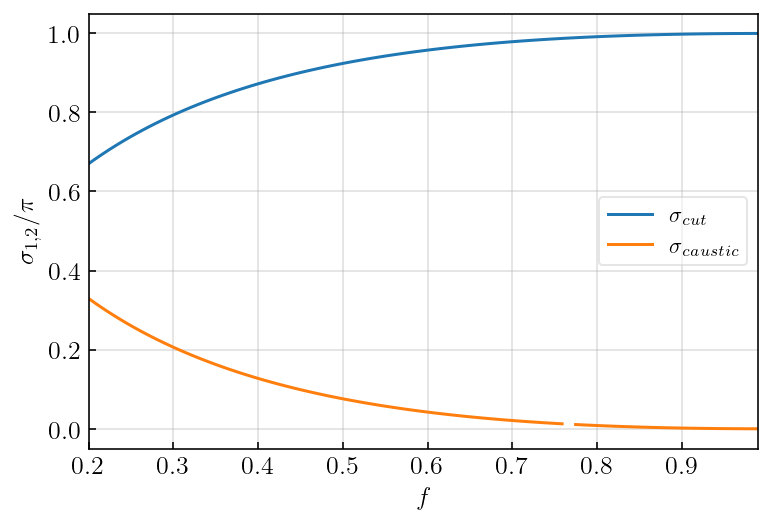

In [6]:
fs = np.linspace(0.2,.99,100)
plt.plot(fs,area_cut_int(fs)/np.pi,label=r'$\sigma_{cut}$')
plt.plot(fs,area_caustic_int(fs)/np.pi,label=r'$\sigma_{caustic}$')


plt.xlabel(r'$f$',fontsize=fontsz)
plt.ylabel(r'$\sigma_{1,2}/\pi$',fontsize=fontsz)
plt.tick_params(axis='both',which='both',direction='in',labelsize=fontsz)
legend = plt.legend(ncol=1,fontsize=fontssz, framealpha=0.5)#,bbox_to_anchor=(0.5,1.02)
plt.setp(legend.get_title(),fontsize=fontssz)
plt.grid(alpha=0.4)
plt.xlim([min(fs),max(fs)])
plt.show()

To be compared with Fig. 3 in [Kormann et al. 1994](http://articles.adsabs.harvard.edu/pdf/1994A%26A...284..285K)

Note that the area of the cut (properly normalized) $\sigma_\mathrm{cut}/\pi<1$ which means that it is smaller than the SIS area. On the other hand, the area of the caustic <1, which means that the region with 4 images is smaller than the SIS region with 2. In the limit of a spherical lens, $\sigma_\mathrm{caustic}\to0$, implying that only 2 images form.

## SIE optical depth

We compute the optical depth including the correction in the area for the cut and caustic. 

The axis ratio $q$ is defined with Rayleigh distribution (A9 in [Haris et al. 2018](https://arxiv.org/pdf/1807.07062.pdf), based on [Collett 2015](https://arxiv.org/pdf/1507.02657.pdf)) 

\begin{equation}
p(q|s)=\frac{1-q}{s^2}\exp\left[-\frac{(1-q)^2}{2s^2}\right]
\end{equation}

We truncate at $q_\mathrm{min}=0.2$ following [Collett 2015](https://arxiv.org/pdf/1507.02657.pdf). We width is fitted to data with

\begin{equation}
s=0.38+5.72 \times 10^{-4} \left(\frac{\sigma}{\mathrm{km/s}}\right)
\end{equation}

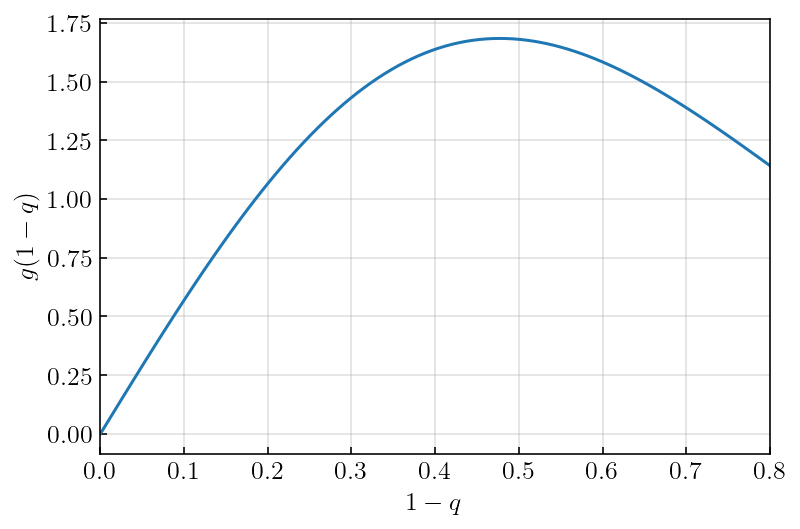

In [10]:
sigma,qmin = 170, 0.2

xs = np.linspace(0.,0.8,100)
gs = lensutils.g_truncated(xs,qmin,sigma)
plt.plot(xs,gs)
plt.xlabel(r'$1-q$',fontsize=fontsz)
plt.ylabel(r'$g(1-q)$',fontsize=fontsz)
plt.tick_params(axis='both',which='both',direction='in',labelsize=fontsz)
plt.grid(alpha=0.4)
plt.xlim([min(xs),max(xs)])
plt.show()

We model the velocity dispersion distribution as in (A3) of [Haris et al. 2018](https://arxiv.org/pdf/1807.07062.pdf), based on (4) of [Choi et al. 2007](https://arxiv.org/abs/astro-ph/0611607)

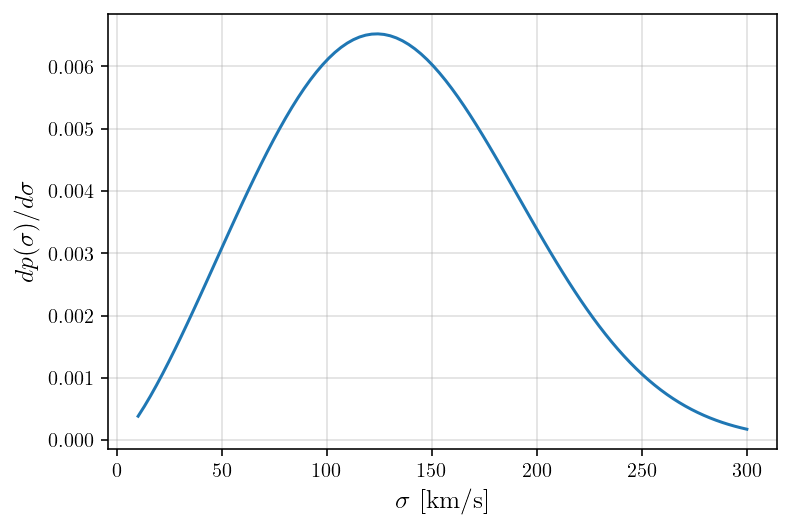

In [25]:
sigma_s = np.linspace(10,300,100)
sigmaS,alpha,beta = 161, 2.32, 2.67
plt.plot(sigma_s, lensutils.dpdsigma(sigma_s,sigmaS,alpha,beta))
plt.xlabel(r'$\sigma$ [km/s]',fontsize=fontsz)
plt.ylabel(r'$d p(\sigma)/d\sigma$',fontsize=fontsz)
plt.grid(alpha=0.4)
plt.show()

In [21]:
zs = np.logspace(-2,1,30)
H0 = cosmo.H(0).value
n = 8e-3 * np.power(H0/100,3) #Mpc^-3
sigmaS, qmin, alpha, beta = 161, 0.2, 2.32, 2.67


Mean tau_sie_double/tau_sis =  0.9112901113124164
Mean tau_sie_quad/tau_sis =  0.09402437255403004
Time taken = 74.42587614059448 seconds


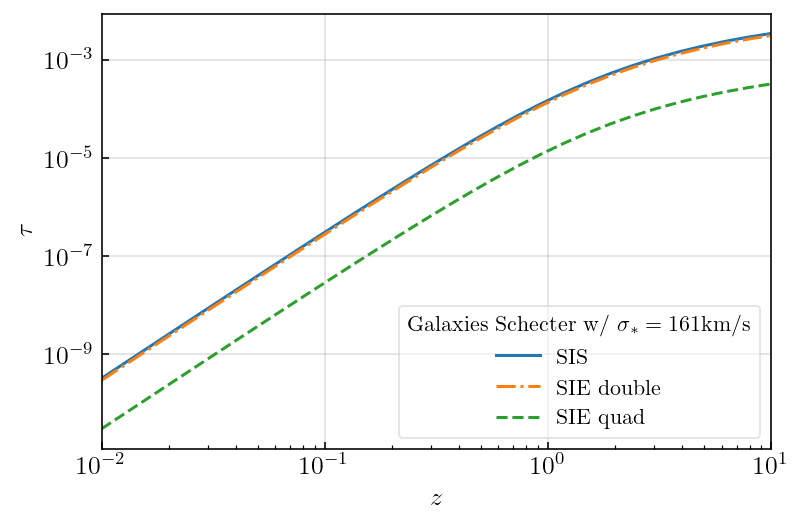

In [22]:
sigmaS_s = np.array([161])
lines = ['-','-.','--']
nz, ns, nqs = 100, 50, 20
i = 0
starttime = time.time()
for sigmaS in sigmaS_s:
    tau = tau_sis.tau_Schechter(zs,n,sigmaS,alpha,beta)
    plt.loglog(zs,tau,lines[0],label='SIS')
    tau_sie_double = tau_sie.tau_Schechter(zs,n,sigmaS,qmin,alpha,beta,nz,ns,nqs,area_cut_int)
    tau_sie_quad = tau_sie.tau_Schechter(zs,n,sigmaS,qmin,alpha,beta,nz,ns,nqs,area_caustic_int)
    plt.loglog(zs,tau_sie_double,lines[1],label='SIE double')
    plt.loglog(zs,tau_sie_quad,lines[2],label='SIE quad')
    i += 1
    print('Mean tau_sie_double/tau_sis = ',np.mean(tau_sie_double/tau))
    print('Mean tau_sie_quad/tau_sis = ',np.mean(tau_sie_quad/tau))
print('Time taken = {} seconds'.format(time.time() - starttime))

plt.xlabel(r'$z$',fontsize=fontsz)
plt.ylabel(r'$\tau$',fontsize=fontsz)
plt.tick_params(axis='both',which='both',direction='in',labelsize=fontsz)
legend = plt.legend(ncol=1,fontsize=fontssz, framealpha=0.5,title=r'Galaxies Schecter w/ $\sigma_*=%s$km/s' % sigmaS)#,bbox_to_anchor=(0.5,1.02)
plt.setp(legend.get_title(),fontsize=fontssz)
plt.grid(alpha=0.4)
plt.xlim([min(zs),max(zs)])
plt.savefig(dir_out+'tau_sis_vs_sie.pdf', bbox_inches='tight', transparent=True)
plt.show()

_Note:_ the dimensionless cut area was not included in [Haris et al. 2018](https://arxiv.org/abs/1807.07062)

*Note:* in [Li et al. 2018](https://arxiv.org/pdf/1802.05089v1.pdf) the optical depth is computed properly including the cut area. They also add an integral for the shear.

# Cut region

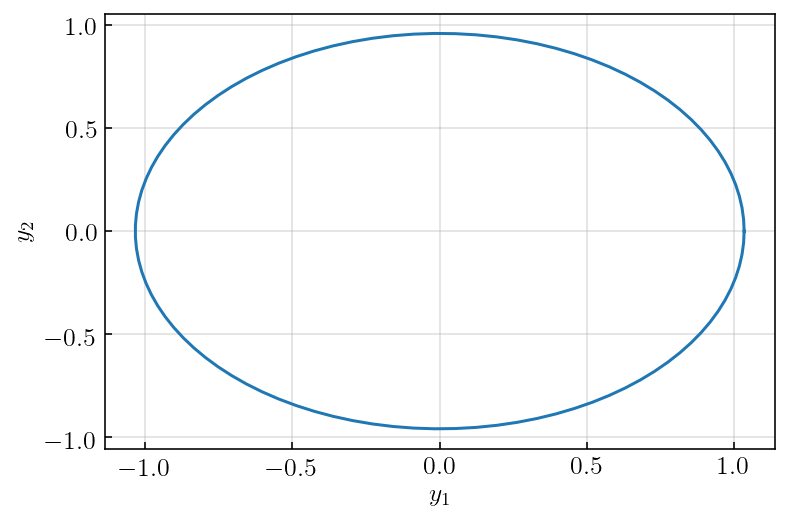

In [ ]:
vth = np.linspace(-np.pi,np.pi,100)
f = 0.8
fp = np.sqrt(1-f**2)
y1 = -(np.sqrt(f)/fp)*np.arcsinh(fp*np.cos(vth)/f)
y2 = -(np.sqrt(f)/fp)*np.arcsin(fp*np.sin(vth))


plt.plot(y1,y2)
plt.xlabel(r'$y_1$',fontsize=fontsz)
plt.ylabel(r'$y_2$',fontsize=fontsz)
plt.tick_params(axis='both',which='both',direction='in',labelsize=fontsz)
plt.grid(alpha=0.4)
plt.show()

Note that the integral for the cut region diverges in the first point of the integral, this is why we start in the next point and check the convergence. 

Also we need many points for the integral to converge.

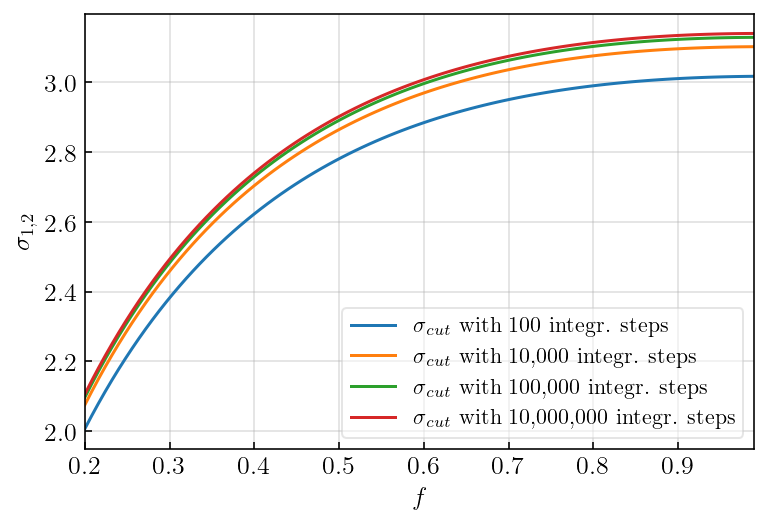

In [23]:
fs = np.linspace(0.2,.99,100)
plt.plot(fs,sie.area_cut(fs,1000),label=r'$\sigma_{cut}$ with 100 integr. steps')
plt.plot(fs,sie.area_cut(fs,10000),label=r'$\sigma_{cut}$ with 10,000 integr. steps')
plt.plot(fs,sie.area_cut(fs,100000),label=r'$\sigma_{cut}$ with 100,000 integr. steps')
plt.plot(fs,sie.area_cut(fs,10000000),label=r'$\sigma_{cut}$ with 10,000,000 integr. steps')
#plt.plot(fs,f_fact*varea_cut(fs,100),'k--',label=r'$\sigma_{cut}$')

plt.xlabel(r'$f$',fontsize=fontsz)
plt.ylabel(r'$\sigma_{1,2}$',fontsize=fontsz)
plt.tick_params(axis='both',which='both',direction='in',labelsize=fontsz)
legend = plt.legend(ncol=1,fontsize=fontssz, framealpha=0.5)#,bbox_to_anchor=(0.5,1.02)
plt.setp(legend.get_title(),fontsize=fontssz)
plt.grid(alpha=0.4)
plt.xlim([min(fs),max(fs)])
plt.show()

In the limit of spherical lens, $f\to1$, $\sigma_\mathrm{cut}\to\pi$